#### Example Notebook

Create a dateset with five Gaussian variables and one spike variable, then document how the code works by demonstrating various features.

    - Shows how to create a run object and perform playouts on it.
    - Shows how to add additional playouts onto existing run object.
    - Shows the full-tree mode and the fixed path mode.
    - Shows how to read/write run objects to disk using shelf module so that one can add more playouts later.
    - Shows how to automatically take a run's top n playouts and rerun the paths with more events.


In [1]:
# Make jupyter notebook display full width to prevent linefeeds in wide tables
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Running in Python
import time
import random
import sys
sys.path.append("../../src")
import CTreeMI as ct
import CTreeUtils as ctu
import mi
import numpy as np
import pandas as pd
import csv
import numpy
import matplotlib.pyplot as plt

In [3]:
# Make a toy dataset for testing

# Number of sig and bkd events
nSig = 5000
nBkd = 5000

# Generate the individual variable distributions
sigV0 = [[np.random.normal(0, 1)] for i in range(nSig)]
sigV1 = [[np.random.normal(0.25, 1)] for i in range(nSig)]
sigV2 = [[np.random.normal(0.5, 1)] for i in range(nSig)]
sigV3 = [[np.random.normal(0.75, 1)] for i in range(nSig)]
sigV4 = [[np.random.normal(1.0, 1)] for i in range(nSig)]
sigV5 = [[np.random.normal(1.25, 1)] for i in range(nSig)]
sigV6 = [[-999] for i in range(nSig)]

bkdV0 = [[np.random.normal(0, 1)] for i in range(nBkd)]
bkdV1 = [[np.random.normal(0, 1)] for i in range(nBkd)]
bkdV2 = [[np.random.normal(0, 1)] for i in range(nBkd)]
bkdV3 = [[np.random.normal(0, 1)] for i in range(nBkd)]
bkdV4 = [[np.random.normal(0, 1)] for i in range(nBkd)]
bkdV5 = [[np.random.normal(0, 1)] for i in range(nBkd)]
bkdV6 = [[-999] for i in range(nBkd)]

# merge variable distributions into sig and bkd datasets
sigVars = mi.joint_space(sigV0, sigV1, sigV2, sigV3, sigV4, sigV5, sigV6)
bkdVars = mi.joint_space(bkdV0, bkdV1, bkdV2, bkdV3, bkdV4, bkdV5, bkdV6)

# add weights to events
# sigWts = [[1.0] for i in range(nSig)]
# bkdWts = [[1.0] for i in range(nBkd)]

sigWts = [[1.0]] * nSig
bkdWts = [[1.0]] * nBkd

# add names and id numbers to variables
varNums = [0, 1, 2, 3, 4, 5, 6]
varNames = ['var0', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6']

# add name to dataset
setName = 'test Gaussian'

# Call routine that creates the dataset object from the above information
myDataset = ct.dataset(setName, sigVars, bkdVars, sigWts, bkdWts, varNums, varNames)

In [4]:
mi.mi(sigV1, bkdV2,k=1,base=2) # just a sanity-check on the continuous MI function.

0.019081748552305038

In [5]:
# Create a run object and pass it a dataset.
# Alternatively, you can read back a run object that you stored from previous running.
# Uncomment one of the following two lines.
myRun = ct.run(myDataset, gateEvalParm=30, nParallelParm=12)
# myRun = ctu.shelfRun(filename='example', mode='read', key='example')

In [6]:
# To launch playouts, you need to pass it a run that you've created, the type of playouts you want, and a
# number of playouts to execute.

# pathType [-1] is compressed tree.

# pathType [-2] is full tree, though how it behaves precisely depends on other arguments used when creating the run and 
# in launching playouts.  See full documentation for details.

# If you pass a list for the type argument, it is interpreted as fixed-path running.  So, for example, passing [1,2,5] will run
# all playouts through variables 1,2,5 only (counting from zero).
startTime = time.time()
print("{:>5s} {:>7s} {:>10s} {:>10s} {:>10s}  {:>10s}".
      format('cycle', 'time', 'pathsopen', 'pathsTstd', 'pathsUntstd', 'highScore'))
for i in range(8):
    cycleStartTime = time.time()
    ct.playouts(myRun, eventsPerPlayout=1000, pathType=[-2], projectedGateDecision=True, pctDefn='absolute',
                cpParm=0.2, banditMode='thresh', banditThreshCut=5.0,
                gateMode='threshPctSignif', gateThreshCut=10.0, gateIncCut=-5.0, gateExcCut=-5.0,
                sampleRandomly=True, numPlays=12)
    print("{:>5d} {:>7.2f} {:>.4e} {:>.4e}  {:>.4e}    {:>8.3f}".
          format(i, time.time() - cycleStartTime, myRun.pathsCount()['nOpen'], 
                 myRun.pathsCount()['nTestedOpen'], myRun.pathsCount()['nUntestedOpen'], myRun.highestScore))
print('----------------------------------')
print('Total elapsed time = {:>7.2f}'.format(time.time() - startTime))

cycle    time  pathsopen  pathsTstd pathsUntstd   highScore
    0    3.49 1.2800e+02 1.2000e+01  1.1600e+02       0.357
    1    3.24 1.2800e+02 2.0000e+01  1.0800e+02       0.365
    2    3.24 1.2800e+02 2.9000e+01  9.9000e+01       0.455
    3    3.32 1.2800e+02 3.6000e+01  9.2000e+01       0.455
    4    3.22 1.2800e+02 3.8000e+01  9.0000e+01       0.455
    5    3.22 1.2800e+02 4.5000e+01  8.3000e+01       0.455
    6    3.22 1.2800e+02 4.9000e+01  7.9000e+01       0.455
    7    3.30 1.2800e+02 4.9000e+01  7.9000e+01       0.455
----------------------------------
Total elapsed time =   26.26


In [7]:
# Note that once a run object is created, you can continue to run playouts on it, and it will continue to accrue
# statistics from the playouts.
# Here, we run more playouts on an existing run object.
startTime = time.time()
print("{:>5s} {:>7s} {:>10s} {:>10s} {:>10s}  {:>10s}".
      format('cycle', 'time', 'pathsopen', 'pathsTstd', 'pathsUntstd', 'highScore'))
for i in range(8):
    cycleStartTime = time.time()
    ct.playouts(myRun, eventsPerPlayout=1000, pathType=[-2], projectedGateDecision=True, pctDefn='absolute',
                cpParm=0.2, banditMode='thresh', banditThreshCut=5.0,
                gateMode='threshPctSignif', gateThreshCut=10.0, gateIncCut=-5.0, gateExcCut=-5.0,
                sampleRandomly=True, numPlays=12)
    print("{:>5d} {:>7.2f} {:>.4e} {:>.4e}  {:>.4e}    {:>8.3f}".
          format(i, time.time() - cycleStartTime, myRun.pathsCount()['nOpen'], 
                 myRun.pathsCount()['nTestedOpen'], myRun.pathsCount()['nUntestedOpen'], myRun.highestScore))
print('----------------------------------')
print('Total elapsed time = {:>7.2f}'.format(time.time() - startTime))

cycle    time  pathsopen  pathsTstd pathsUntstd   highScore
    0    3.51 1.2800e+02 5.5000e+01  7.3000e+01       0.455
    1    3.23 1.2800e+02 5.9000e+01  6.9000e+01       0.455
    2    3.61 6.4000e+01 3.1000e+01  3.3000e+01       0.455
    3    3.37 6.4000e+01 3.3000e+01  3.1000e+01       0.455
    4    3.55 6.4000e+01 3.5000e+01  2.9000e+01       0.455
    5    3.59 6.4000e+01 3.5000e+01  2.9000e+01       0.450
    6    3.68 1.6000e+01 7.0000e+00  9.0000e+00       0.450
    7    3.58 1.6000e+01 7.0000e+00  9.0000e+00       0.450
----------------------------------
Total elapsed time =   28.15


In [8]:
# Here, we force completion of any paths that are still open but that haven't been tested (note the change in "banditMode" argument)
startTime = time.time()
print("{:>5s} {:>7s} {:>10s} {:>10s} {:>10s}  {:>10s}".
      format('cycle', 'time', 'pathsopen', 'pathsTstd', 'pathsUntstd', 'highScore'))
for i in range(8):
    cycleStartTime = time.time()
    ct.playouts(myRun, eventsPerPlayout=1000, pathType=[-2], projectedGateDecision=True, pctDefn='absolute',
                cpParm=0.2, banditMode='untested', banditThreshCut=5.0,
                gateMode='threshPctSignif', gateThreshCut=10.0, gateIncCut=-5.0, gateExcCut=-5.0,
                sampleRandomly=True, numPlays=12)
    print("{:>5d} {:>7.2f} {:>.4e} {:>.4e}  {:>.4e}    {:>8.3f}".
          format(i, time.time() - cycleStartTime, myRun.pathsCount()['nOpen'], 
                 myRun.pathsCount()['nTestedOpen'], myRun.pathsCount()['nUntestedOpen'], myRun.highestScore))
print('----------------------------------')
print('Total elapsed time = {:>7.2f}'.format(time.time() - startTime))

cycle    time  pathsopen  pathsTstd pathsUntstd   highScore
    0    3.36 1.6000e+01 1.3000e+01  3.0000e+00       0.450
    1    3.28 1.6000e+01 1.6000e+01  0.0000e+00       0.450
    2    3.34 1.6000e+01 1.6000e+01  0.0000e+00       0.450
    3    3.26 1.6000e+01 1.6000e+01  0.0000e+00       0.450
    4    3.27 1.6000e+01 1.6000e+01  0.0000e+00       0.441
    5    3.27 1.6000e+01 1.6000e+01  0.0000e+00       0.441
    6    3.36 1.6000e+01 1.6000e+01  0.0000e+00       0.441
    7    3.74 1.6000e+01 1.6000e+01  0.0000e+00       0.441
----------------------------------
Total elapsed time =   26.89


In [9]:
# Note that once a run object is created, you can continue to run playouts on it, and it will continue to accrue
# statistics from the playouts.  
#  Here, we run some fixed-path playouts on an existing run object
ct.playouts(myRun,0,[0], numPlays=1)
ct.playouts(myRun,0,[1], numPlays=1)
ct.playouts(myRun,0,[2], numPlays=1)
ct.playouts(myRun,0,[3], numPlays=1)
ct.playouts(myRun,0,[4], numPlays=1)
ct.playouts(myRun,0,[5], numPlays=1)
ct.playouts(myRun,0,[6], numPlays=1)

In [26]:
# Report text information for the current run.
# The report results are cumulative.  So if you do more playouts later using the same run and then call 
# for a report, the new report will include results from all playouts that have ever been done on that run object.
ct.textReports(myRun,playoutsToReport=0,includeGateInfo=True)

Run Info
gateEvalParm = [30] nodeEvalParm = 5 nParallel = 12
Dataset Info:           dataset name    nVar    nSig    nBkd  Sig Sample Eff  Bkd Sample Eff
                       test Gaussian       7    5000    5000            1.00            1.00
------------------------------------------------------------
               0 var0                                            
               1 var1                                            
               2 var2                                            
               3 var3                                            
               4 var4                                            
               5 var5                                            
               6 var6                                            
----------------------------------------
Number of playouts =  295
Highest scoring path =   0.441
Range of Classification Error Bounds for top MI =    0.130 -    0.279
Results lists for 5 highest scoring paths (score, nVar, varLis

In [27]:
# Write the run object (which has all completed playouts) to a file so you can load it back in later
# and continue playouts from where you left off.
ctu.shelfRun(filename='example', mode='write', key='example', myRunIn=myRun)

In [28]:
# uncomment if you want to delete the persisted run object in the shelf file.
# ctu.shelfRun(filename='example', mode='delete', key='example')

#### Create a new run object so you can run other playouts without affecting the previous set of playouts

In [29]:
# Create a run object and pass it a dataset
myRun2 = ct.run(myDataset, gateEvalParm=30, nParallelParm=12)

In [30]:
# Run a few playouts on this new run object
startTime = time.time()
print("{:>5s} {:>7s} {:>10s} {:>10s} {:>10s}  {:>10s}".
      format('cycle', 'time', 'pathsopen', 'pathsTstd', 'pathsUntstd', 'highScore'))
for i in range(16):
    cycleStartTime = time.time()
    ct.playouts(myRun2, eventsPerPlayout=1000, pathType=[-2], projectedGateDecision=True, pctDefn='absolute',
                cpParm=0.2, banditMode='thresh', banditThreshCut=5.0,
                gateMode='threshPctSignif', gateThreshCut=10.0, gateIncCut=-5.0, gateExcCut=-5.0,
                sampleRandomly=True, numPlays=12)
    print("{:>5d} {:>7.2f} {:>.4e} {:>.4e}  {:>.4e}    {:>8.3f}".
          format(i, time.time() - cycleStartTime, myRun.pathsCount()['nOpen'], 
                 myRun2.pathsCount()['nTestedOpen'], myRun.pathsCount()['nUntestedOpen'], myRun.highestScore))
print('----------------------------------')
print('Total elapsed time = {:>7.2f}'.format(time.time() - startTime))

cycle    time  pathsopen  pathsTstd pathsUntstd   highScore
    0    3.53 1.2300e+02 1.2000e+01  4.2000e+01       0.441
    1    3.31 1.2300e+02 1.6000e+01  4.2000e+01       0.441
    2    3.33 1.2300e+02 2.5000e+01  4.2000e+01       0.441
    3    3.58 1.2300e+02 3.3000e+01  4.2000e+01       0.441
    4    3.44 1.2300e+02 3.9000e+01  4.2000e+01       0.441
    5    3.67 1.2300e+02 4.4000e+01  4.2000e+01       0.441
    6    3.30 1.2300e+02 4.7000e+01  4.2000e+01       0.441
    7    3.27 1.2300e+02 5.1000e+01  4.2000e+01       0.441
    8    3.35 1.2300e+02 5.7000e+01  4.2000e+01       0.441
    9    3.41 1.2300e+02 6.1000e+01  4.2000e+01       0.441
   10    3.42 1.2300e+02 6.1000e+01  4.2000e+01       0.441
   11    3.42 1.2300e+02 1.7000e+01  4.2000e+01       0.441
   12    3.47 1.2300e+02 1.8000e+01  4.2000e+01       0.441
   13    3.41 1.2300e+02 1.8000e+01  4.2000e+01       0.441
   14    3.31 1.2300e+02 1.1000e+01  4.2000e+01       0.441
   15    3.31 1.2300e+02 1.1000e+01  4.2

#### Read back the old run object from file, add more playouts to it, then write it back to file.

In [31]:
# Read the first run object back off the shelf.
myRunReadBack = ctu.shelfRun(filename='example', mode='read', key='example')

In [32]:
# Run a few more playouts on the run object you read back, then print updated information, and then rewrite the run object to file.
# Writing and then reading-back run objects allows true continuation of runs.
ct.playouts(myRunReadBack, eventsPerPlayout=1000, pathType=[-2], projectedGateDecision=True, pctDefn='absolute',
                cpParm=0.2, banditMode='thresh', banditThreshCut=5.0,
                gateMode='threshPctSignif', gateThreshCut=10.0, gateIncCut=-5.0, gateExcCut=-5.0,
                sampleRandomly=True, numPlays=12)
ct.textReports(myRunReadBack,playoutsToReport=0, includeGateInfo=True)
ctu.shelfRun(filename='example', mode='write', key='example', myRunIn=myRunReadBack)

Run Info
gateEvalParm = [30] nodeEvalParm = 5 nParallel = 12
Dataset Info:           dataset name    nVar    nSig    nBkd  Sig Sample Eff  Bkd Sample Eff
                       test Gaussian       7    5000    5000            1.00            1.00
------------------------------------------------------------
               0 var0                                            
               1 var1                                            
               2 var2                                            
               3 var3                                            
               4 var4                                            
               5 var5                                            
               6 var6                                            
----------------------------------------
Number of playouts =  307
Highest scoring path =   0.441
Range of Classification Error Bounds for top MI =    0.130 -    0.279
Results lists for 5 highest scoring paths (score, nVar, varLis

In [33]:
# Note that the shelf file will continue to grow each time you write back to it.  
# This can be a problem in cases where the output is large.  And because the run object 
# has a copy of the dataset, the output will be large in all cases where the dataset
# is large.
# Depending on the underlying DB implementation, there are two ways of handling this.
#  1) If the implementation allows for db reorganization, just execute the following on the file:
#     (Be sure the file has been properly closed or you'll get an error when opening it.)
#     import dbm
#     db=dbm.open('myfile.db',flag='w')
#     db.reorganize() 
#     db.close()
#  2) If the implementation doesn't support db reorganization, then you need to:
#       a) read the desired run object from the shelf file
#       b) complete more playouts on the run object
#       c) write the run object to a new db file
#       d) delete the old db file

In [34]:
#  Now replay the 10 best performing paths using all the events
ct.replayBest(myRunReadBack,10,0)
ct.textReports(myRunReadBack,playoutsToReport=0, includeGateInfo=True)

Run Info
gateEvalParm = [30] nodeEvalParm = 5 nParallel = 12
Dataset Info:           dataset name    nVar    nSig    nBkd  Sig Sample Eff  Bkd Sample Eff
                       test Gaussian       7    5000    5000            1.00            1.00
------------------------------------------------------------
               0 var0                                            
               1 var1                                            
               2 var2                                            
               3 var3                                            
               4 var4                                            
               5 var5                                            
               6 var6                                            
----------------------------------------
Number of playouts =  317
Highest scoring path =   0.440
Range of Classification Error Bounds for top MI =    0.131 -    0.280
Results lists for 5 highest scoring paths (score, nVar, varLis

In [36]:
# Print playout reports but restrict them only to playouts with specific numbers of variables used.
# Note that the best playout w/, n variables shown here is not necessarily the best that one could have achieved
# with n variables.  The reason is that these playouts were initially run w/o any limit on the 
# number of variables.  So, the paths with only a small number of variables (which is what you're looking at
# here) were competing against the top overall paths rather than against the top paths with only n variables.  
# This isn't the same as letting the MC tree run freely but telling it to only ever use n variables.  
# The result below is correct for what it is, but it's important to understand the limitation on the result.
for nVar in range(1,8):
    print("Report restricted to playouts with number of variables =", nVar)
    ct.playoutsReport(myRunReadBack, numToReport=0, sortByScore=True, nVarRestrict=nVar)

Report restricted to playouts with number of variables = 1
            gates status for each var      inc/exc status for each var   play            number                 
   # 10987654321098765432109876543210 10987654321098765432109876543210   type cpParm Paths Open  nEvents   score
 240                          3333333                          0100000     -2  0.200  1.280e+02     1000   0.257
 248                          3333333                          0100000  fixed  0.707  1.000e+00     5000   0.244
 268                          3333333                          0010000  fixed  0.707  1.000e+00     5000   0.163
 274                          3333333                          0001000     -2  0.200  1.280e+02     1000   0.142
 290                          3333333                          0001000  fixed  0.707  1.000e+00     5000   0.100
 291                          3333333                          0001000     -2  0.200  1.280e+02     1000   0.097
 299                          3333333

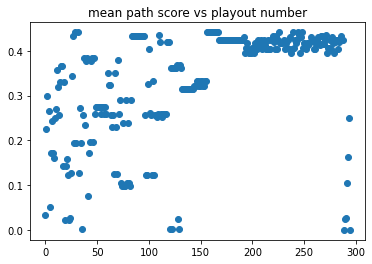

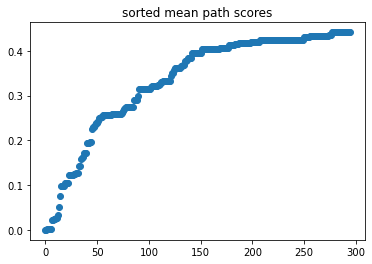

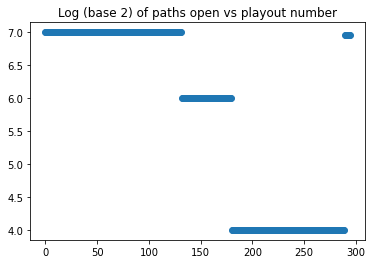

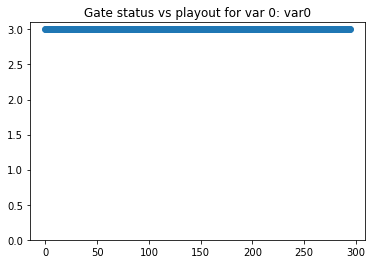

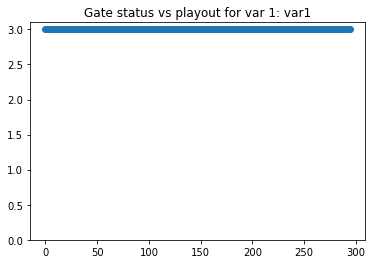

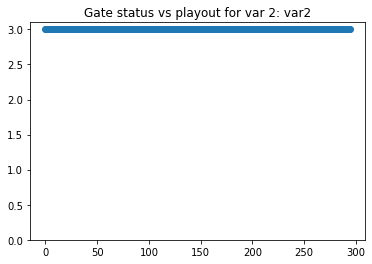

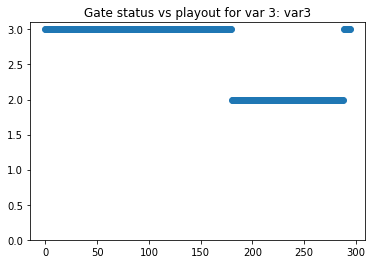

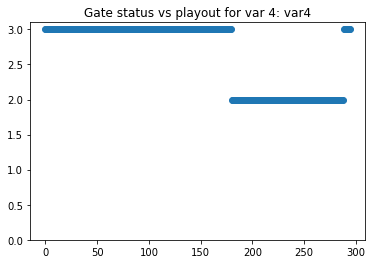

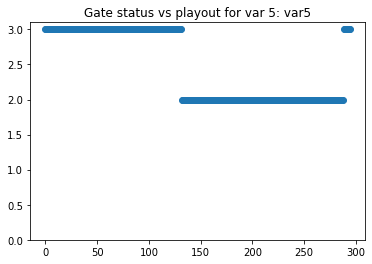

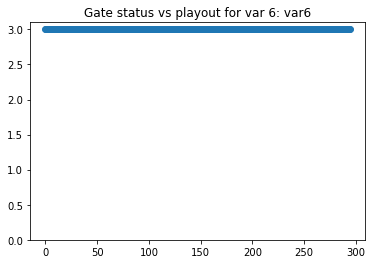

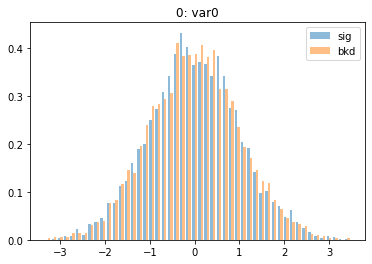

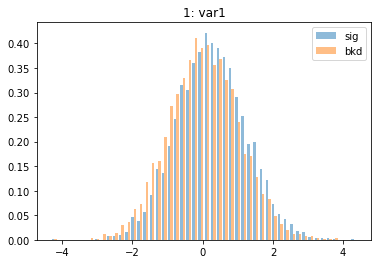

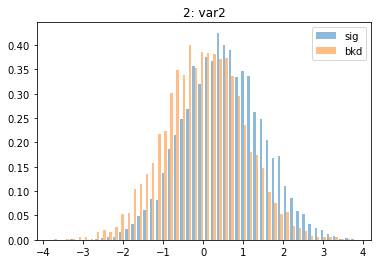

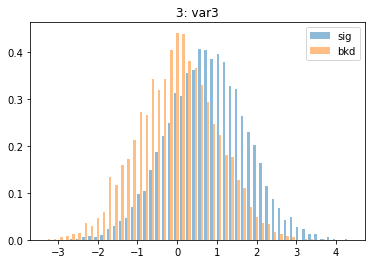

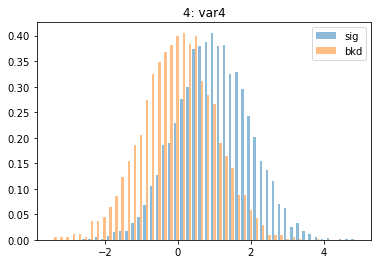

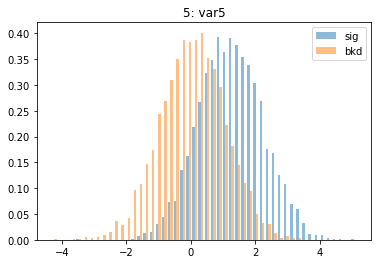

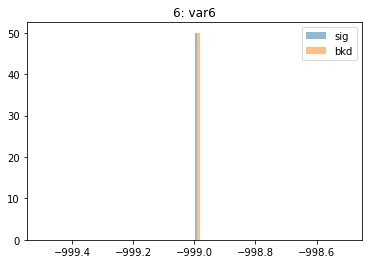

In [37]:
# Report plot-based information for the current run.
# The report results will be cumulative if you later do more playouts using the same run.
ct.plotReports(myRun,'myPlots_1.pdf',includeGateInfo=True)

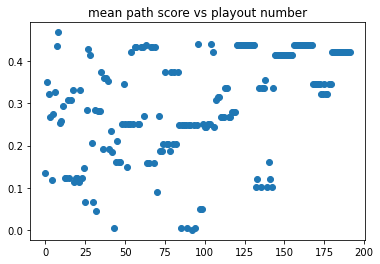

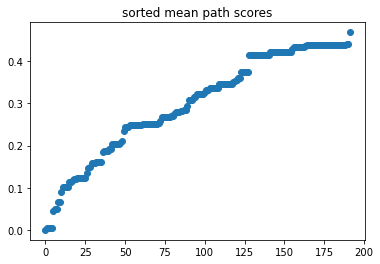

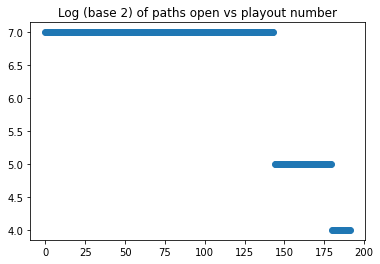

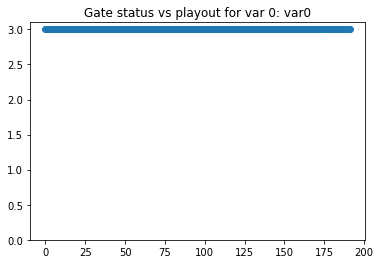

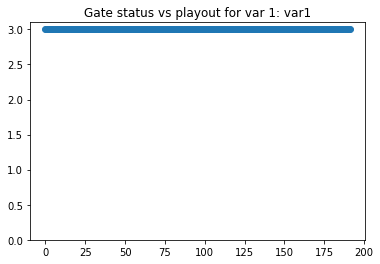

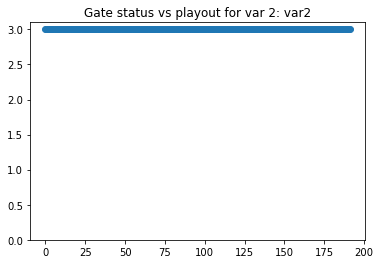

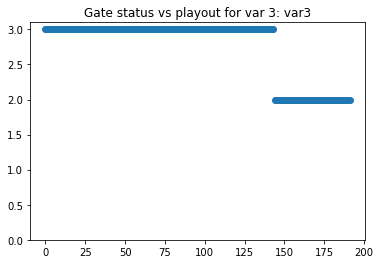

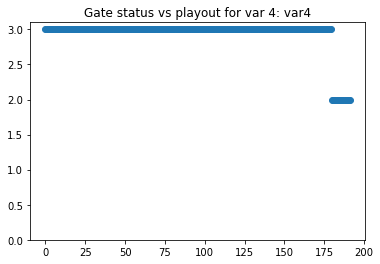

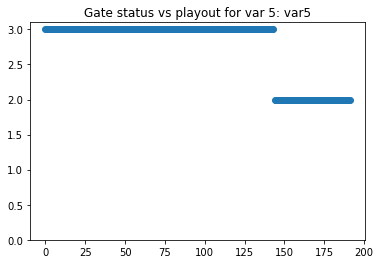

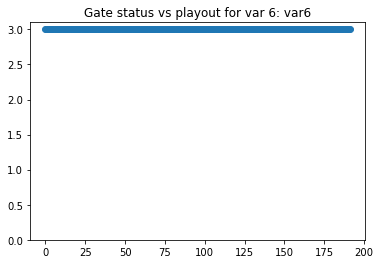

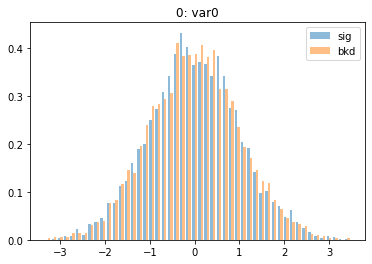

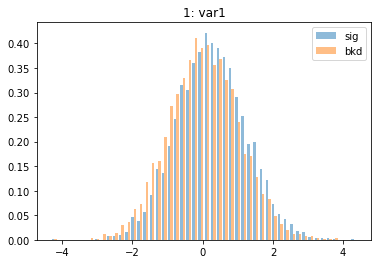

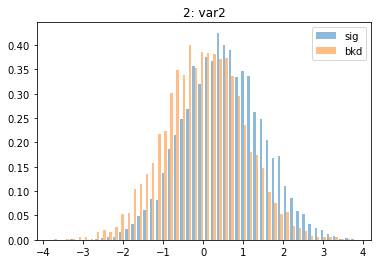

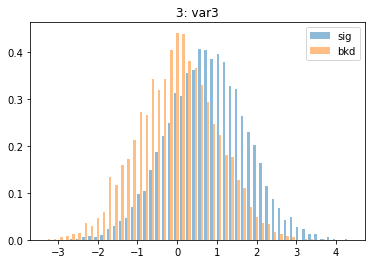

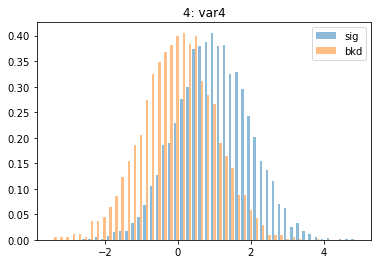

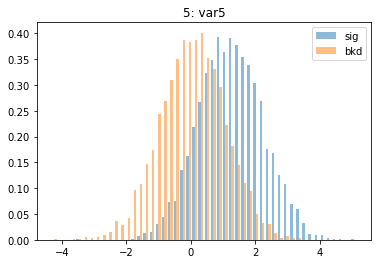

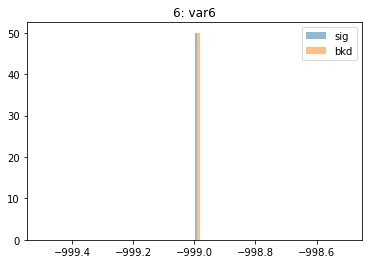

In [38]:
# Report plot-based information for the current run.
# The report results will be cumulative if you later do more playouts using the same run.
ct.plotReports(myRun2,'myPlots_2.pdf',includeGateInfo=True)